In [62]:
# Cell 1: Imports
import os
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model
from sklearn.neural_network import MLPClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model saving
import joblib

print("Libraries imported successfully")





Libraries imported successfully


In [63]:
# Cell 2: Load Dataset
DATA_PATH = "../Data/processed/fused_ppg_acc_features.csv"
df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
df.head()



Dataset shape: (1158, 29)


,subject_id,activity,hr_bpm,hrv,peak_count,R_ratio,red_ac,ir_ac,ppg_mean,ppg_std,...,ax_rms,ay_rms,az_rms,sma,ax_energy,ay_energy,az_energy,ax_entropy,ay_entropy,az_entropy
0,s12,run,99.709182,0.007644,9,1.580212,98.586438,256.296416,-1.116858,68.371286,...,0.885659,0.973383,1.063934,2.341158,1959.412897,2366.793253,2827.628172,2.212839,3.306854,2.456894
1,s12,run,100.190840,0.011256,8,1.036670,91.672293,219.962447,2.855715,59.774673,...,0.964208,1.238615,1.235612,2.775671,2322.382918,3832.352997,3813.791349,2.711380,3.213158,2.860193
2,s12,run,93.541203,0.036374,8,1.550534,93.461807,202.217577,2.343746,59.500541,...,0.961333,1.306386,1.200691,2.766003,2308.557564,4263.198379,3601.265495,2.204404,2.552857,2.353520
3,s12,run,86.248203,0.019813,7,1.098686,85.358685,185.129674,-2.086325,58.417425,...,0.965035,1.500704,1.392992,3.060616,2326.371625,5625.781375,4847.190902,2.584731,2.832697,2.625304
4,s12,run,85.836910,0.017000,7,-0.962195,73.637724,182.366085,-0.376455,58.327658,...,0.865292,1.424049,1.335625,2.864869,1870.330840,5065.739702,4456.168899,2.685710,3.077220,2.545995


In [64]:
# Cell 3: Select only top features + label
selected_features = [
    'ax_rms', 'ax_std', 'ay_energy', 'peak_count', 'az_entropy',
    'ax_energy', 'az_rms', 'ppg_rms', 'az_std', 'sma',
    'ax_entropy', 'ay_entropy', 'az_energy', 'ay_rms',
    'red_ac', 'ay_std'
]

X = df[selected_features]
y = df["activity"]

print("Selected feature matrix shape:", X.shape)
print("Unique activity labels:", y.unique())


Selected feature matrix shape: (1158, 16)
Unique activity labels: ['run' 'sit' 'walk']


In [51]:
# Cell 3: Separate features and labels
X = df.drop(columns=["subject_id", "activity"])
y = df["activity"]

print("Feature matrix shape:", X.shape)
print("Unique activity labels:", y.unique())



Feature matrix shape: (1158, 27)
Unique activity labels: ['run' 'sit' 'walk']


In [65]:
# Cell 4: Encode activity labels
# Cell 4: Encode activity labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Activity encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))



Activity encoding mapping: {'run': np.int64(0), 'sit': np.int64(1), 'walk': np.int64(2)}


In [66]:
# Cell 5: Function to sort subjects numerically
# Cell 5: Sort subjects numerically
def subject_number(s):
    return int(s.replace("s", ""))

subjects = sorted(df["subject_id"].unique(), key=subject_number)
print("All subjects found:", subjects)




All subjects found: ['s12', 's22']


In [67]:
#LEAVE ONE SUBJECT OUT!
# Cell 6: Split subjects into train/test (70%-30%)
# Cell 6: Leave-one-subject-out split (70%-30%)
n_subjects = len(subjects)
split_idx = int(0.7 * n_subjects)

train_subjects = subjects[:split_idx]
test_subjects  = subjects[split_idx:]

print("Train subjects:", train_subjects)
print("Test subjects:", test_subjects)


Train subjects: ['s12']
Test subjects: ['s22']


In [68]:
# Cell 7: Split dataframe based on subjects
# Cell 7: Split dataframe based on subjects
train_df = df[df["subject_id"].isin(train_subjects)].reset_index(drop=True)
test_df  = df[df["subject_id"].isin(test_subjects)].reset_index(drop=True)

# Features and labels
X_train = train_df[selected_features]
y_train = le.transform(train_df["activity"])

X_test = test_df[selected_features]
y_test = le.transform(test_df["activity"])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)





X_train shape: (578, 16)
y_train shape: (578,)
X_test shape: (580, 16)
y_test shape: (580,)


In [69]:
# Cell 8: Feature scaling (fit on train, transform test)
# Cell 8: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("Feature scaling applied")




Feature scaling applied


In [70]:
# Cell 9: Define MLP model
# Cell 9: Define MLP model
mlp = MLPClassifier(
    hidden_layer_sizes=(64,32),
    activation="relu",
    solver="adam",
    max_iter=500,
    random_state=42
)
mlp




MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)

In [71]:
# Cell 10: Train MLP
mlp.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = mlp.predict(X_test_scaled)

print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)



y_pred shape: (580,)
y_test shape: (580,)


In [72]:
# Cell 11: Test Accuracy & Classification Report
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))



Test Accuracy: 0.6810

Classification Report:
              precision    recall  f1-score   support

         run       0.55      1.00      0.71       194
         sit       0.89      1.00      0.94       193
        walk       1.00      0.04      0.08       193

    accuracy                           0.68       580
   macro avg       0.81      0.68      0.58       580
weighted avg       0.81      0.68      0.58       580



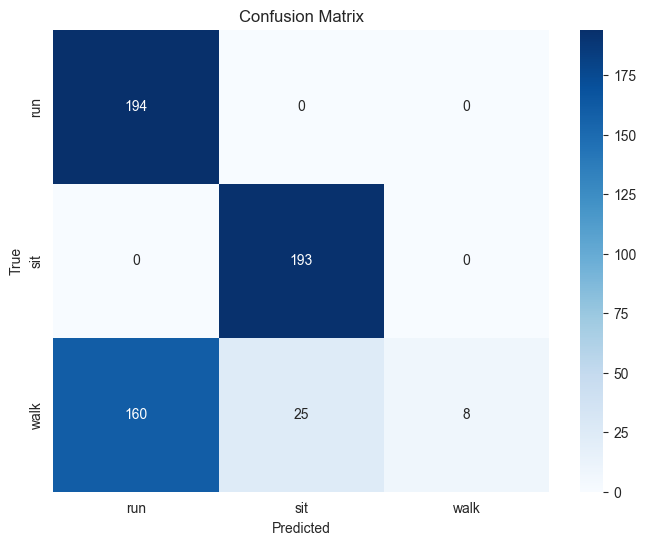

In [73]:
# Cell 12: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()




In [75]:
# Cell 13: Save trained MLP model and scaler
os.makedirs("models", exist_ok=True)

joblib.dump(mlp, "models/activity_classification_mlp.pkl")
joblib.dump(scaler, "models/activity_scaler.pkl")

print("Activity MLP model and scaler saved successfully!")




Activity MLP model and scaler saved successfully!


In [77]:
# Save LabelEncoder
joblib.dump(le, "models/activity_label_encoder.pkl")
print("Activity LabelEncoder saved successfully!")


Activity LabelEncoder saved successfully!
